In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [98]:
# load our localization data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

# load kilosort localization data
_, ks_trials = data_preprocess.load_kilosort_localizations_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=30_000)

In [99]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [100]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


In [101]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] 
ks_structured_unsorted = np.vstack([ks_trials[i] for i in trials_ids])[:,1:]

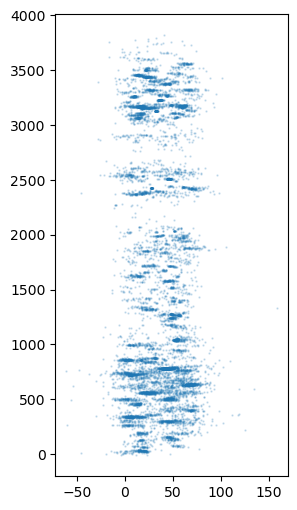

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
axes[0].scatter(x=structured_unsorted[:10_000,0], y=structured_unsorted[:10_000,1], s=.5, alpha=.2)
axes[1].scatter(x=ks_structured_unsorted[:10_000,0], y=ks_structured_unsorted[:10_000,1], s=.5, alpha=.2);

visualize our localization

In [ ]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=300, seed=seed, fit_model=False)
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

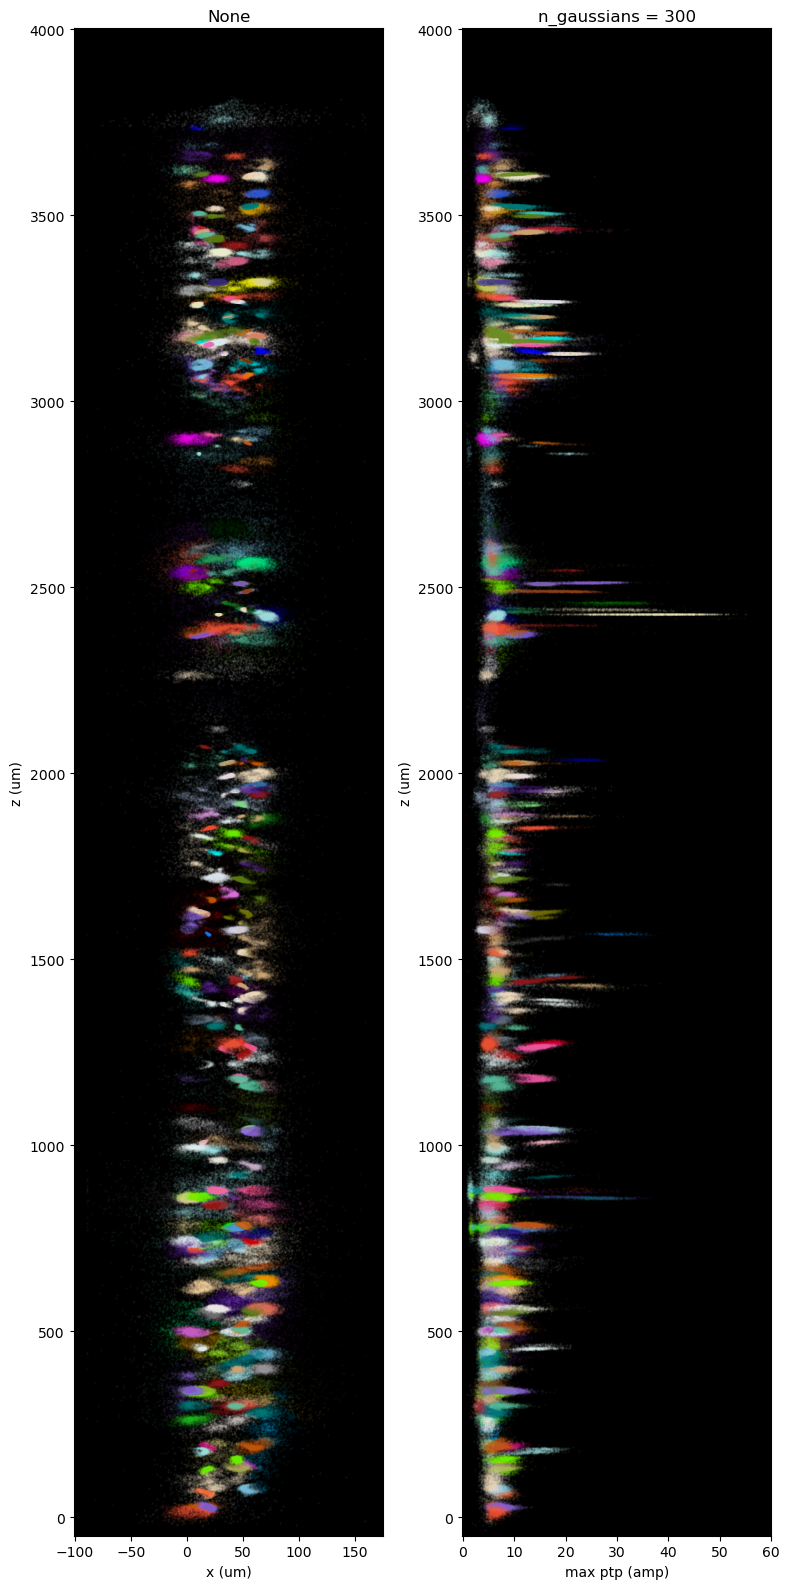

In [31]:
viz_tools.plot_gaussian_mixtures(sub_id, structured_unsorted, initial_labels, initial_labels, display_all_spikes=True, n_spikes_display=1_000)

visualize kilosort localization

model selection using AIC:

https://stats.stackexchange.com/questions/577/is-there-any-reason-to-prefer-the-aic-or-bic-over-the-other

In [123]:
sample_spikes = [trial[np.random.choice(len(trial), 1000), 1:] for trial in trials]
sample_spikes = np.vstack(sample_spikes)

In [ ]:
from sklearn.mixture import GaussianMixture

lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(250, 355, 5)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

--- fitting MoG with 250 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 6102694.66 bic: 6128548.9
best aic MoG has 250 gaussians.
best bic MoG has 250 gaussians.
--- fitting MoG with 255 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 6101971.09 bic: 6128342.62
best aic MoG has 255 gaussians.
best bic MoG has 255 gaussians.
--- fitting MoG with 260 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
current aic: 6102804.97 bic: 6129693.79
best aic MoG has 255 gaussians.
best bic MoG has 255 gaussians.
--- fitting MoG with 265 gaussians ---
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
current aic: 6097687.83 bic: 6125093.95
best aic MoG has 265 gaussians.
best bic MoG has 265 gaussians.
--- fitting MoG with 270 gaussians ---
Initialization 0
  Iteration 10
 